In [121]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
%autoreload 2

In [101]:
import dask
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np
import dask.array as da
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import xarray as xr
import numpy as np
import scipy.ndimage
from skimage.measure import regionprops 
from skimage.measure import label as label_np
import dask.array as dsa
from sklearn.metrics.pairwise import haversine_distances
import pandas as pd


print('loaded libraries')

loaded libraries


In [123]:
import ocetrac

In [124]:
from ocetrac import Tracker

In [4]:
dir_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
mt_path = "/pub/mariant3/WarmWaterMasses/data/"
ds = xr.open_dataset(f"{dir_path}/data/ocean_daily_cmip.01860101-01901231.tos.nc", chunks={'time':100})
ds_region = ds.sel(xh=slice(-130, -70), yh=slice(8, 38)) #.sel(xh = slice(-138, 0), yh = slice(8, 49))
static = xr.open_dataset(f"{dir_path}/data/ocean_daily_cmip.static.nc")
static_region = static.sel(xh=slice(-130, -70), yh=slice(8, 38))
#ds_static_region = xr.merge([static_region,ds_region])
#labels = xr.open_dataset("/pub/mariant3/WarmWaterMasses/data/01860315-01891101-ocetrac-v3-labels-region.nc")
#labels = xr.open_mfdataset(f"{mt_path}/ocetracv5/ocetrac-v5-processed/ocetrac-v5-blobs-clim-t4*.nc", chunks={'time':1}).blobs.load()

In [50]:
manso = pd.read_pickle(f"{mt_path}ocetracv6/ocetrac-v6-processed/ocetrac-v6-blobs-tos-t1-df-r1-msq0-0186-03-15-0189-12-14.pkl")
manso;

In [51]:
manso.date

0                                            [0186-03-28]
1                                            [0186-03-28]
2       [0186-04-07, 0186-04-08, 0186-04-09, 0186-04-1...
3                                            [0186-04-08]
4                                [0186-04-09, 0186-04-10]
                              ...                        
1121                                         [0189-11-12]
1122                                         [0189-11-16]
1123    [0189-11-17, 0189-11-18, 0189-11-19, 0189-11-2...
1124    [0189-11-20, 0189-11-21, 0189-11-22, 0189-11-2...
1125     [0189-11-24, 0189-11-25, 0189-11-26, 0189-11-27]
Name: date, Length: 1126, dtype: object

In [104]:
labels = xr.open_mfdataset(f"{mt_path}/ocetracv6/ocetrac-v6-processed/ocetrac-v6-blobs-tos-t1*manso.nc", chunks={'time':1}).blobs.compute()

In [105]:
labels = labels.sel(time=slice("0186-03-28","0186-04-10"))

In [60]:
ds_labels_region = xr.merge([ds_region,labels],join='inner')
ds_labels_static_region = xr.merge([static_region,ds_labels_region],join='inner') #previously ds_static_region

In [106]:
ids = np.unique(labels)
ids = np.array([id for id in ids if ~np.isnan(id)])
ids

array([ 39., 136., 210., 220., 224., 225.])

In [107]:
num_events = len(ids)
num_events

6

In [108]:
ssta = ds_labels_static_region.tos

In [125]:
tracker = Tracker(
    da=ds_region.tos,
    static=ds_labels_static_region,
    mask=None,
    radius=3,
    min_size_quartile=0.25,
    timedim='time',
    xdim='xh',
    ydim='yh',
    positive=True
)

In [126]:
df = tracker.collect_surface_stats(labels)
df

<xarray.DataArray 'blobs' (time: 1, yh: 1, xh: 1)>
array([[[39.]]])
Coordinates:
  * xh       (xh) float64 -76.5
  * yh       (yh) float64 8.222
  * time     (time) object 0186-03-28 12:00:00

<xarray.DataArray 'tos' (time: 1, yh: 1, xh: 1)>
dask.array<where, shape=(1, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-03-28 12:00:00
  * xh       (xh) float64 -76.5
  * yh       (yh) float64 8.222
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

<xarray.DataArray 'tos' (time: 1, yh: 1, xh: 1)>
dask.array<eq, shape=(1, 1, 1), dtype=bool, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-03-28 12:00:00
  * xh       (xh) float64 -76.5
  * yh       (yh) float64 8.222

<xarray.DataArray 'blobs' (time: 1, yh: 4, xh: 7)>
array([[[136., 136., 136., 136., 136., 136.,  nan],
        [136., 136., 136., 136., 136., 136., 136.],
        [ nan, 136., 136., 136.,  nan,  nan,  nan],
        [ nan,  nan, 136.,  nan,  nan,  nan,  nan]]])
Coordinates:
  * xh       (xh) float64 -97.58 -97.33 -97.08 -96.82 -96.57 -96.31 -96.06
  * yh       (yh) float64 12.89 13.13 13.38 13.62
  * time     (time) object 0186-03-28 12:00:00

<xarray.DataArray 'tos' (time: 1, yh: 4, xh: 7)>
dask.array<where, shape=(1, 4, 7), dtype=float32, chunksize=(1, 4, 7), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-03-28 12:00:00
  * xh       (xh) float64 -97.58 -97.33 -97.08 -96.82 -96.57 -96.31 -96.06
  * yh       (yh) float64 12.89 13.13 13.38 13.62
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

<xarray.DataArray 'tos' (time: 1, yh: 4, xh: 7)>
dask.array<eq, shape=(1, 4, 7), dtype=bool, chunksize=(1, 4, 7), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-03-28 12:00:00
  * xh       (xh) float64 -97.58 -97.33 -97.08 -96.82 -96.57 -96.31 -96.06
  * yh       (yh) float64 12.89 13.13 13.38 13.62

<xarray.DataArray 'blobs' (time: 4, yh: 6, xh: 6)>
array([[[ nan,  nan,  nan,  nan,  nan,  nan],
        [ nan, 210.,  nan,  nan,  nan,  nan],
        [ nan, 210., 210., 210.,  nan,  nan],
        [ nan, 210., 210.,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan]],

       [[ nan,  nan,  nan,  nan,  nan,  nan],
        [ nan, 210., 210., 210., 210.,  nan],
        [210., 210., 210., 210., 210.,  nan],
        [210., 210., 210., 210., 210.,  nan],
        [210., 210., 210.,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan]],

       [[ nan,  nan, 210., 210.,  nan,  nan],
        [ nan, 210., 210., 210., 210.,  nan],
        [ nan, 210., 210., 210., 210.,  nan],
        [210., 210., 210., 210., 210.,  nan],
        [210., 210., 210.,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan,  nan]],

       [[ nan,  nan,  nan,  nan,  nan,  nan],
        [ nan, 210., 210., 210., 210.,  nan],
        [210., 210., 210., 210., 210., 210.],
        [210., 210., 210., 210., 210., 210.],
        [210., 210., 210., 210.,  nan,  nan],
        [210., 210.,  nan,  nan,  nan,  nan]]])
Coordinates:
  * xh       (xh) float64 -98.86 -98.6 -98.35 -98.09 -97.84 -97.58
  * yh       (yh) float64 14.35 14.59 14.83 15.07 15.31 15.56
  * time     (time) object 0186-04-07 12:00:00 ... 0186-04-10 12:00:00

<xarray.DataArray 'tos' (time: 4, yh: 6, xh: 6)>
dask.array<where, shape=(4, 6, 6), dtype=float32, chunksize=(4, 6, 6), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-04-07 12:00:00 ... 0186-04-10 12:00:00
  * xh       (xh) float64 -98.86 -98.6 -98.35 -98.09 -97.84 -97.58
  * yh       (yh) float64 14.35 14.59 14.83 15.07 15.31 15.56
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

<xarray.DataArray 'tos' (time: 4, yh: 6, xh: 6)>
dask.array<eq, shape=(4, 6, 6), dtype=bool, chunksize=(4, 6, 6), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-04-07 12:00:00 ... 0186-04-10 12:00:00
  * xh       (xh) float64 -98.86 -98.6 -98.35 -98.09 -97.84 -97.58
  * yh       (yh) float64 14.35 14.59 14.83 15.07 15.31 15.56

<xarray.DataArray 'blobs' (time: 1, yh: 1, xh: 1)>
array([[[220.]]])
Coordinates:
  * xh       (xh) float64 -97.33
  * yh       (yh) float64 15.07
  * time     (time) object 0186-04-08 12:00:00

<xarray.DataArray 'tos' (time: 1, yh: 1, xh: 1)>
dask.array<where, shape=(1, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-04-08 12:00:00
  * xh       (xh) float64 -97.33
  * yh       (yh) float64 15.07
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

<xarray.DataArray 'tos' (time: 1, yh: 1, xh: 1)>
dask.array<eq, shape=(1, 1, 1), dtype=bool, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-04-08 12:00:00
  * xh       (xh) float64 -97.33
  * yh       (yh) float64 15.07

<xarray.DataArray 'blobs' (time: 2, yh: 3, xh: 4)>
array([[[ nan,  nan,  nan,  nan],
        [224., 224., 224.,  nan],
        [ nan, 224., 224., 224.]],

       [[ nan, 224.,  nan,  nan],
        [ nan, 224., 224., 224.],
        [ nan, 224., 224.,  nan]]])
Coordinates:
  * xh       (xh) float64 -97.58 -97.33 -97.08 -96.82
  * yh       (yh) float64 13.86 14.11 14.35
  * time     (time) object 0186-04-09 12:00:00 0186-04-10 12:00:00

<xarray.DataArray 'tos' (time: 2, yh: 3, xh: 4)>
dask.array<where, shape=(2, 3, 4), dtype=float32, chunksize=(2, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-04-09 12:00:00 0186-04-10 12:00:00
  * xh       (xh) float64 -97.58 -97.33 -97.08 -96.82
  * yh       (yh) float64 13.86 14.11 14.35
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

<xarray.DataArray 'tos' (time: 2, yh: 3, xh: 4)>
dask.array<eq, shape=(2, 3, 4), dtype=bool, chunksize=(2, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-04-09 12:00:00 0186-04-10 12:00:00
  * xh       (xh) float64 -97.58 -97.33 -97.08 -96.82
  * yh       (yh) float64 13.86 14.11 14.35

<xarray.DataArray 'blobs' (time: 1, yh: 1, xh: 1)>
array([[[225.]]])
Coordinates:
  * xh       (xh) float64 -96.57
  * yh       (yh) float64 15.07
  * time     (time) object 0186-04-09 12:00:00

<xarray.DataArray 'tos' (time: 1, yh: 1, xh: 1)>
dask.array<where, shape=(1, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-04-09 12:00:00
  * xh       (xh) float64 -96.57
  * yh       (yh) float64 15.07
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

<xarray.DataArray 'tos' (time: 1, yh: 1, xh: 1)>
dask.array<eq, shape=(1, 1, 1), dtype=bool, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-04-09 12:00:00
  * xh       (xh) float64 -96.57
  * yh       (yh) float64 15.07

,id,dates,coords,centroid,duration,intensity_max,intensity_mean,intensity_min,intensity_cumulative,total_area,area,distance
0,39,[0186-03-28],"[([8.22163897284192], [-76.49719618069989])]","[[-76.0, 8.0]]",1,[29.017515],[29.017515],[29.017515],29.017515,1,[758747800.0],[[nan]]
1,136,[0186-03-28],"[([12.889873669635012, 12.889873669635012, 12....","[[-96.0, 13.0]]",1,[29.120079],[29.059717],[29.00637],494.015198,17,[12490594000.0],[[nan]]
2,210,"[0186-04-07, 0186-04-08, 0186-04-09, 0186-04-10]","[([14.589726512825457, 14.831531473953534, 14....","[[-98.0, 14.0], [-98.0, 14.0], [-98.0, 14.0], ...",4,"[29.035416, 29.163082, 29.19532, 29.234726]","[29.018019, 29.080574, 29.096212, 29.118254]","[29.00061, 29.016766, 29.01853, 29.001623]",1832.811279,24,"[4341889000.0, 12295158000.0, 13025446000.0, 1...","[[nan], [0.0], [0.0], [111.19492664455854]]"
3,220,[0186-04-08],"[([15.073066511750687], [-97.32987229325035])]","[[-97.0, 15.0]]",1,[29.005522],[29.005522],[29.005522],29.005522,1,[722297700.0],[[nan]]
4,224,"[0186-04-09, 0186-04-10]","[([14.105322883430246, 14.105322883430246, 14....","[[-97.0, 14.0], [-97.0, 14.0]]",2,"[29.043283, 29.04856]","[29.021551, 29.016363]","[29.010565, 29.000925]",348.227478,8,"[4367308300.0, 4370401300.0]","[[nan], [0.0]]"
5,225,[0186-04-09],"[([15.073066511750687], [-96.567003842069])]","[[-96.0, 15.0]]",1,[29.006014],[29.006014],[29.006014],29.006014,1,[722297700.0],[[nan]]


In [127]:
area_list_new_manso = [event_area.sum() for event_area in df.area.values]
area_list_new_manso = [event_area.sum() for event_area in df.area.values]
intensity_list_new_manso = [(event_maxint.max()-29) for event_maxint in df.intensity_max.values]
df['max_intensity_max'] = intensity_list_new_manso
df['cumulative_area']= area_list_new_manso

In [137]:
display(df.dates[2])
display(manso.date[2])

array(['0186-04-07', '0186-04-08', '0186-04-09', '0186-04-10'],
      dtype='datetime64[D]')

array(['0186-04-07', '0186-04-08', '0186-04-09', '0186-04-10',
       '0186-04-11'], dtype='datetime64[D]')

In [ ]:
manso

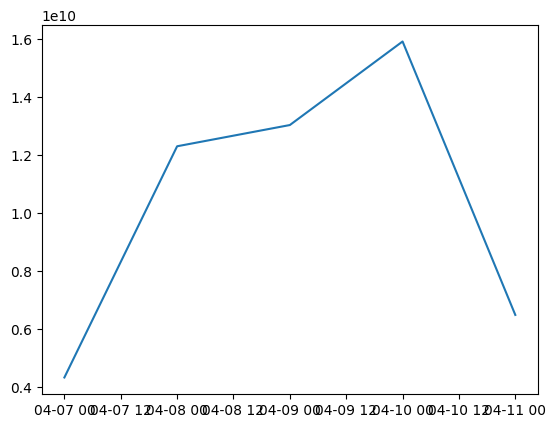

In [136]:
plt.plot(manso.date[2],manso.area[2])

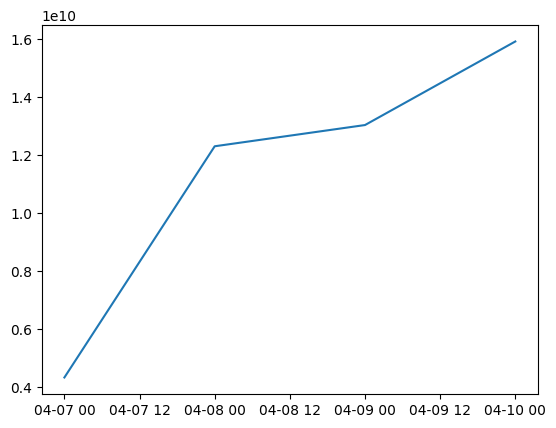

In [129]:
plt.plot(df.dates[2],df.area[2])

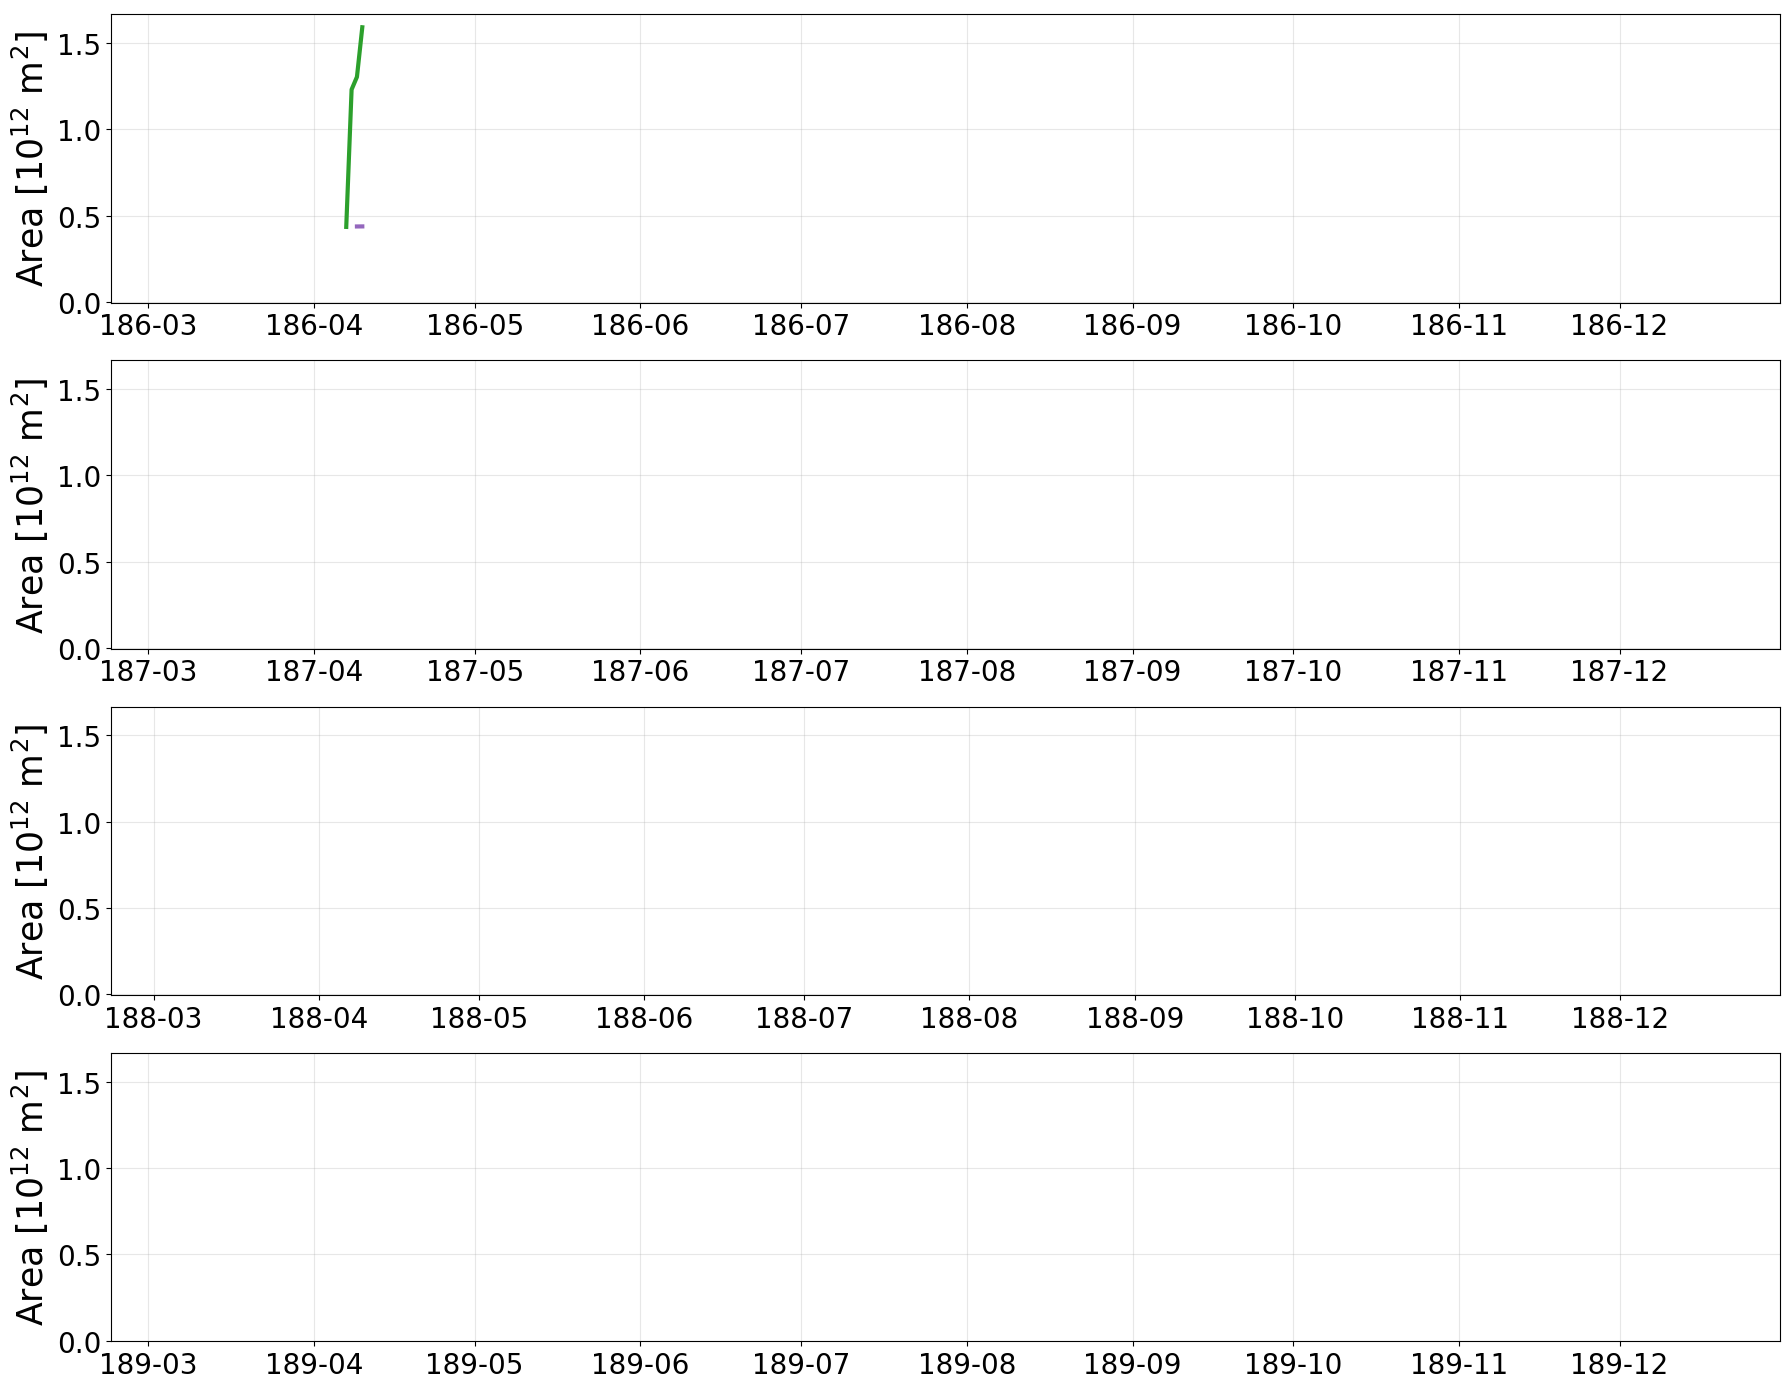

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
fontsize = 20
years = ['0186', '0187', '0188', '0189']  # Years to plot

fig, axs = plt.subplots(len(years), 1, figsize=(18, 3.5 * len(years)))  # Adjusting height based on number of subplots fig, axs = plt.subplots(len(years), 1, figsize=(18, 3.5 * len(years)))  
#fig.set_facecolor('#faf8eb')

for i, year in enumerate(years):
    year_start = f'{year}-02-22'
    year_end = f'{year}-12-31'
    
    for j in range(len(df['area'].values)):
        axs[i].plot(df.dates[j], df.area[j], label=f'MHW {manso.id[j]}', linewidth=3)
    
    axs[i].set_xlim(np.datetime64(year_start), np.datetime64(year_end)) #year_start
   # axs[i].set_ylim(0e+12, 3.20e+12)
    axs[i].set_ylabel(r"Area [10$^{12}$ m${^2}$]", fontsize=25)
    axs[i].tick_params(axis='x', labelsize=fontsize)
    axs[i].tick_params(axis='y', labelsize=fontsize)
    #axs[i].set_yticks(np.arange(0e+12, 3.20e+12 + 0.3e+12, 0.3e+12))
    axs[i].grid(True, alpha=0.3)
    
    #axs[i].set_title(f'Year {year}', fontsize=20)

    offset_text = axs[i].yaxis.get_offset_text()
    offset_text.set_fontsize(1)
    offset_text.set_color('w')

plt.tight_layout()
#plt.savefig(f'/pub/mariant3/WarmWaterMasses/figures/area-evolution-paper.png', bbox_inches='tight')
#plt.savefig(f'/pub/mariant3/WarmWaterMasses/figures/paper/ocetrac-v5-area-evolution-t1.png', bbox_inches='tight')
plt.show()

In [94]:
manso

,id,date,coords,centroid,duration,intensity_max,intensity_mean,intensity_min,intensity_cumulative,area
0,39,[0186-03-28],"[([8.22163897284192], [-76.49719618069989])]",NaN,1,[29.017515],[29.017515],[29.017515],29.017515,[758747800.0]
1,136,[0186-03-28],"[([12.889873669635012, 12.889873669635012, 12....",NaN,1,[29.120079],[29.059717],[29.00637],494.015198,[12490594000.0]
2,210,"[0186-04-07, 0186-04-08, 0186-04-09, 0186-04-1...","[([14.589726512825457, 14.831531473953534, 14....",NaN,5,"[29.035416, 29.163082, 29.19532, 29.234726, 29...","[29.018019, 29.080574, 29.096212, 29.118254, 2...","[29.00061, 29.016766, 29.01853, 29.001623, 29....",2094.147949,"[4341889000.0, 12295158000.0, 13025446000.0, 1..."
3,220,[0186-04-08],"[([15.073066511750687], [-97.32987229325035])]",NaN,1,[29.005522],[29.005522],[29.005522],29.005522,[722297700.0]
4,224,"[0186-04-09, 0186-04-10]","[([14.105322883430246, 14.105322883430246, 14....",NaN,2,"[29.043283, 29.04856]","[29.021551, 29.016363]","[29.010565, 29.000925]",348.227478,"[4367308300.0, 4370401300.0]"
...,...,...,...,...,...,...,...,...,...,...
1121,7570,[0189-11-12],"[([9.210078121568138], [-80.04971042048845])]",NaN,1,[29.008205],[29.008205],[29.008205],29.008205,[754758900.0]
1122,7605,[0189-11-16],"[([9.456768240176679], [-75.48265376058285])]",NaN,1,[29.01919],[29.01919],[29.01919],29.019190,[753695000.0]
1123,7608,"[0189-11-17, 0189-11-18, 0189-11-19, 0189-11-2...","[([8.71618532806131], [-76.49719618069989]), (...",NaN,6,"[29.106436, 29.262722, 29.13803, 29.187286, 29...","[29.106436, 29.166527, 29.13803, 29.187286, 29...","[29.106436, 29.070333, 29.13803, 29.187286, 29...",233.095856,"[756807040.0, 1512603400.0, 756807040.0, 75680..."
1124,7626,"[0189-11-20, 0189-11-21, 0189-11-22, 0189-11-2...","[([9.456768240176679], [-75.48265376058285]), ...",NaN,10,"[29.058964, 29.159037, 29.1661, 29.14241, 29.1...","[29.058964, 29.159037, 29.1661, 29.14241, 29.1...","[29.058964, 29.159037, 29.1661, 29.14241, 29.1...",291.308441,"[753695000.0, 753695000.0, 753695000.0, 753695..."


In [86]:
display(manso.loc[manso.id==210].date.values)
display(manso.loc[manso.id==210].duration.values)

array([array(['0186-04-07', '0186-04-08', '0186-04-09', '0186-04-10',
              '0186-04-11'], dtype='datetime64[D]')                  ],
      dtype=object)

array([5])

In [74]:
event = labels.where(labels == 210, drop=True)

In [88]:
len(event.time)

4

In [72]:
len(labels.where(labels == 210, drop=True).time)

4

In [13]:
class Tracker:
    def __init__(self, da, mask, radius, min_size_quartile, timedim, xdim, ydim, positive=True):
        
        self.da = da
        self.static = ds_labels_static_region
        self.mask = mask
        self.radius = radius
        self.min_size_quartile = min_size_quartile
        self.timedim = timedim
        self.xdim = xdim
        self.ydim = ydim   
        self.positive = positive
        
        if ((timedim, ydim, xdim) != da.dims):
            try:
                da = da.transpose(timedim, ydim, xdim) 
            except:
                raise ValueError(f'Ocetrac currently only supports 3D DataArrays. The dimensions should only contain ({timedim}, {xdim}, and {ydim}). Found {list(da.dims)}')

    def collect_surface_stats(self, labels: xr.DataArray) -> pd.DataFrame:
        '''
        Collects surface statistics from labeled marine heatwaves.
    
        Parameters
        ----------
        labels : DataArray
            The labeled marine heatwaves events. 
    
        Returns
        -------
        df_events : DataFrame
            Summary surface statistics for each identified and tracked marine heatwave. 
        '''
    
        ids = np.unique(labels.values)
        ids = ids[np.isfinite(ids)]
        
        dataframes = []    
        for id in ids:
            event = labels.where(labels == id, drop=True)
            df = self._get_surface_stats(event) 
            dataframes.append(df)
    
        df_events = pd.concat(dataframes, ignore_index=True)
        return df_events


    def _compute_distance(self,lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        '''
        Compute distance in kilometers between two coordinates.
    
        Parameters
        ----------
        lat1 : float
            The latitude of the first point.
        lon1 : float
            The longitude of the first point.
        lat2 : float
            The latitude of the second point.
        lon2 : float
            The longitude of the second point.
    
        Returns
        -------
        distance : float
            Distance in km between the first and second points.
        '''
    
        dist = haversine_distances(
            np.deg2rad(np.array([(lat1, lon1)])),
            np.deg2rad(np.array([(lat2, lon2)])),
        ).squeeze()
        
        dist = dist * 6371000 / 1000  # multiply by Earth radius to get kilometers
    
        return dist

    def _get_surface_stats(self, event: xr.DataArray) -> pd.DataFrame:
        '''
        Get the statistics of surface marine heatwaves identified.
        
        Parameters
        ----------
        event : DataArray
            The labeled marine heatwave event. 
    
        Returns
        -------
        mhw : DataFrame
            Summary statistic for a single marine heatwave.
        
        '''
        
        # Initialize dictionary 
        mhw = {}
        mhw['id'] = [] # event label
        mhw['dates'] = [] # datetime format
        mhw['coords'] = [] # (lat, lon)
        mhw['centroid'] = []  # (lat, lon)
        mhw['duration'] = [] # [months]
        mhw['intensity_max'] = [] # [deg C]
        mhw['intensity_mean'] = [] # [deg C]
        mhw['intensity_min'] = [] # [deg C]
        mhw['intensity_cumulative'] = [] # [deg C]
        mhw['total_area'] = [] # [km2]
        mhw['area'] = [] # [km2]
        mhw['distance'] = [] 
        
        # TO ADD:
        # mhw['rate_onset'] = [] # [deg C / month]
        # mhw['rate_decline'] = [] # [deg C / month]
    
        mhw["id"].append(int(np.nanmedian(event.values)))
        mhw["dates"].append(event[self.timedim].values)
        mhw["duration"] = event[self.timedim].shape[0]
        mhw["total_area"] = int(event.sum(self.timedim).where(event.sum(self.timedim)>0, other=np.nan).count((self.ydim, self.xdim)).values)
    
        # for time_slice in event[self.timedim]:
        #     event_slice = event.sel({self.timedim: time_slice})
    
        #     try:
        #         area_count = int(event_slice.where(event_slice > 0, other=np.nan).count((self.ydim, self.xdim)).values)
        #     except ValueError:
        #         area_count = np.nan
                 
        #     mhw['area'].append(area_count)
    
            
        # try:
        #     mhw['area'].append(int(event.where(event > 0, other=np.nan).count((self.ydim, self.xdim)).values))
        # except ValueError:
        #     mhw['area'].append(np.nan)
            
        centroid_array = np.full((event[self.timedim].shape[0], 2), np.nan) 
        distance_array = np.full((event[self.timedim].shape[0], 1), np.nan) 
            
        for i, time in enumerate(event[self.timedim].values):
            mhw_slice = event.where(event[self.timedim]==time, drop=True)
            
            # Create latitude and longitude grids
            lon_grid, lat_grid = np.meshgrid(np.arange(0, mhw_slice[self.xdim].shape[0]), np.arange(0, mhw_slice[self.ydim].shape[0]))
            lon_flat = lon_grid.flatten()
            lat_flat = lat_grid.flatten()
            data_flat = mhw_slice.values.flatten()
        
            # Compute the centroid
            centroid_lon = np.nansum(lon_flat * data_flat) / np.nansum(data_flat)
            centroid_lat = np.nansum(lat_flat * data_flat) / np.nansum(data_flat)
    
            coords = [int(mhw_slice[self.xdim][round(centroid_lon)].values), int(mhw_slice[self.ydim][round(centroid_lat)].values)]
            centroid_array[i,:] = coords
            
            # Extract lat and lon from the current coordinates
            lon2, lat2 = coords  # lon2 is the first element, lat2 is the second
            
            # Calculate distance from previous coordinates, if available
            if i != 0:  # if not the first centroid
                lon1, lat1 = centroid_array[i-1,:]  # gets previous centroid
                distance = self._compute_distance(lat1, lon1, lat2, lon2)
                distance_array[i,:] = distance
        
        event_ssta = self.da.where(event > 0, drop=True)
        event_ssta_mask = event_ssta == event_ssta
        
        mhw['centroid'].append(centroid_array)
        mhw['distance'].append(distance_array)
        
        
        # mhw['intensity_mean'].append((ds_labels_static_region.tos).where(event_ssta).mean(['xh','yh']).values)
        mhw['intensity_mean'].append((self.da).where(event_ssta).mean([self.xdim,self.ydim]).values)
        mhw['intensity_min'].append((self.da).where(event_ssta).min([self.xdim,self.ydim]).values)
        mhw['intensity_max'].append((self.da).where(event_ssta).max([self.xdim,self.ydim]).values)
        mhw['intensity_cumulative'].append(np.nansum(event_ssta))
        
    
        event_area = (self.static.areacello).where(event_ssta).sum([self.xdim,self.ydim])
        cell_area = event_area.values
        mhw['area'].append(cell_area)

        
        coords = event.stack(z=(self.ydim, self.xdim))
        coord_pairs = [(coords.isel(time=t[0]).dropna(dim='z', how='any').z[self.ydim].values, 
                          coords.isel(time=t[0]).dropna(dim='z', how='any').z[self.xdim].values) for t in enumerate(event.time)]
    
        mhw['coords'].append(coord_pairs)
    
        return pd.DataFrame(mhw)

In [ ]:
tracker = Trackers(
    da=ds,
    mask=None,
    radius=3,
    min_size_quartile=0.75,
    timedim='time',
    xdim='xh',
    ydim='yh',
    positive=True
)

In [ ]:
df = tracker.collect_surface_stats(labels)

In [ ]:
df

In [ ]:
def _get_surface_stats(self, event: xr.DataArray) -> pd.DataFrame:
    '''
    Get the statistics of surface marine heatwaves identified.
    
    Parameters
    ----------
    event : DataArray
        The labeled marine heatwave event. 

    Returns
    -------
    mhw : DataFrame
        Summary statistic for a single marine heatwave.
    
    '''
    
    # Initialize dictionary 
    mhw = {}
    mhw['id'] = [] # event label
    mhw['dates'] = [] # datetime format
    mhw['coords'] = [] # (lat, lon)
    mhw['centroid'] = []  # (lat, lon)
    mhw['duration'] = [] # [months]
    mhw['intensity_max'] = [] # [deg C]
    mhw['intensity_mean'] = [] # [deg C]
    mhw['intensity_min'] = [] # [deg C]
    mhw['intensity_cumulative'] = [] # [deg C]
    mhw['total_area'] = [] # [km2]
    #mhw['area'] = [] # [km2]
    mhw['distance'] = [] 
    
    # TO ADD:
    # mhw['rate_onset'] = [] # [deg C / month]
    # mhw['rate_decline'] = [] # [deg C / month]
    
    mhw["id"].append(int(np.nanmedian(event.values)))
    #mhw["dates"].append(event[self.timedim].values)

    mhw["duration"] = event[self.timedim].shape[0]
    mhw["total_area"] = int(event.sum(self.timedim).where(event.sum(self.timedim)>0, other=np.nan).count((self.ydim, self.xdim)).values)

    # for time_slice in event[self.timedim]:
    #     event_slice = event.sel({self.timedim: time_slice})

    #     try:
    #         area_count = int(event_slice.where(event_slice > 0, other=np.nan).count((self.ydim, self.xdim)).values)
    #     except ValueError:
    #         area_count = np.nan
             
    #     mhw['area'].append(area_count)

        
    # try:
    #     mhw['area'].append(int(event.where(event > 0, other=np.nan).count((self.ydim, self.xdim)).values))
    # except ValueError:
    #     mhw['area'].append(np.nan)
        
    centroid_array = np.full((event[self.timedim].shape[0], 2), np.nan) 
    distance_array = np.full((event[self.timedim].shape[0], 1), np.nan) 
            
    for i, time in enumerate(event[self.timedim].values):
        mhw_slice = event.where(event[self.timedim]==time, drop=True)
        
        # Create latitude and longitude grids
        lon_grid, lat_grid = np.meshgrid(np.arange(0, mhw_slice[self.xdim].shape[0]), np.arange(0, mhw_slice[self.ydim].shape[0]))
        lon_flat = lon_grid.flatten()
        lat_flat = lat_grid.flatten()
        data_flat = mhw_slice.values.flatten()
    
        # Compute the centroid
        centroid_lon = np.nansum(lon_flat * data_flat) / np.nansum(data_flat)
        centroid_lat = np.nansum(lat_flat * data_flat) / np.nansum(data_flat)

        coords = [int(mhw_slice[self.xdim][round(centroid_lon)].values), int(mhw_slice[self.ydim][round(centroid_lat)].values)]
        centroid_array[i,:] = coords
        
        # Extract lat and lon from the current coordinates
        lon2, lat2 = coords  # lon2 is the first element, lat2 is the second
        
        # Calculate distance from previous coordinates, if available
        if i != 0:  # if not the first centroid
            lon1, lat1 = centroid_array[i-1,:]  # gets previous centroid
            distance = self._compute_distance(lat1, lon1, lat2, lon2)
            distance_array[i,:] = distance
    

    mhw['centroid'].append(centroid_array)
    mhw['distance'].append(distance_array)


    event_ssta = self.da.where(event > 0, drop=True)
    
    coords = event.stack(z=(self.ydim, self.xdim))
    coord_pairs = [(coords.isel(time=t[0]).dropna(dim='z', how='any').z[self.ydim].values, 
                      coords.isel(time=t[0]).dropna(dim='z', how='any').z[self.xdim].values) for t in enumerate(event.time)]
    
    mhw['coords'].append(coord_pairs)
    
    return pd.DataFrame(mhw)

In [ ]:
import os, glob
import xarray as xr
import numpy as np
import pandas as pd
import warnings
from skimage.measure import label as label_np
from skimage.measure import regionprops 

try:
    from tqdm.auto import tqdm
    tqdm_avail = True
except:
    warnings.warn(
        "Optional dependency `tqdm` not found. This will make progressbars a lot nicer. \
    Install with `conda install -c conda-forge tqdm`"
    )
    tqdm_avail = False
    
def _wrap(labels):
    ''' Impose periodic boundary and wrap labels, then reorder the labels'''
    first_column = labels[..., 0]
    last_column = labels[..., -1]

    stacked = first_column.stack(z=['time','yh'])
    unique_first = np.unique(stacked[stacked.notnull()])

    # This loop iterates over the unique values in the first column, finds the location of those values in 
    # the first columnm and then uses that index to replace the values in the last column with the first column value
    for i in enumerate(unique_first):
        first = np.where(first_column == i[1])
        last = last_column[first[0], first[1]]
        stacked = last.stack(z=['time','yh'])
        bad_labels = np.unique(stacked[stacked.notnull()])
        replace = np.isin(labels, bad_labels)
        labels = labels.where(replace==False, other=i[1])
    
    labels = labels.fillna(0)
    labels_wrapped = np.unique(labels, return_inverse=True)[1].reshape(labels.shape)
    labels_wrapped = xr.DataArray(labels_wrapped, dims=labels.dims, coords=labels.coords)

    return labels_wrapped

def _get_labels(binary_images):
    '''function used to label binary images at each time step using skimage.measure.label'''
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels
    
def _get_centroids(sub_labels):
    '''This function uses skimage.measure.regionprops to find the centroids of objects assigned 
    to each unique label'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.yh[round(p.centroid[0])].values),
                  float(sub_labels.xh[round(p.centroid[1])].values)) for p in props]
    for i in range(0,len(centroids)):
        if centroids[i][1] >= 359.875:
            centroids[i] = (centroids[i][0], list(centroids[i])[1] - 359.875)
    
    return centroids

def _get_intensity_area(event, ssta, mhw):
    '''Calculates event intensities and area at each time interval using anomaly data and coordinates 
    cooresponding to the event.'''
    
    event_ssta = ssta.where(event>0, drop=True)        
    event_ssta_mask = event_ssta == event_ssta
    #mhw['intensity_mean'].append(event_ssta.mean(('yh','xh')).values)
    #mhw['intensity_max'].append(event_ssta.max(('yh','xh')).values) 
    #mhw['intensity_min'].append(event_ssta.min(('yh','xh')).values)
    mhw['intensity_mean'].append((ds_labels_static_region.tos).where(event_ssta_mask).mean(['xh','yh']).values)
    mhw['intensity_min'].append((ds_labels_static_region.tos).where(event_ssta_mask).min(['xh','yh']).values)
    mhw['intensity_max'].append((ds_labels_static_region.tos).where(event_ssta_mask).max(['xh','yh']).values)
   
    #event_temperature_max = (ds_static_region.tos).where(event_mask).sel(xh = slice(-138, 0), yh = slice(8, 49)).max(['xh','yh'])
 
    mhw['intensity_cumulative'].append(np.nansum(event_ssta))
    coords = event.stack(z=('yh','xh'))
    coord_pairs = [(coords.isel(time=t[0]).dropna(dim='z', how='any').z.yh.values, 
                      coords.isel(time=t[0]).dropna(dim='z', how='any').z.xh.values) for t in enumerate(event.time)]

    mhw['coords'].append(coord_pairs)
    
    # Calculate weighted cell area assuming 0.25º resolution data and 111 km per degree of latitude
    
    #for id in ids:
        #print(id)
        #print(i)
        #events = labels.where(labels==id, drop=True)
        #event_mask = events == id
   # event_area
    #event_mask = events == event
    event_ssta_mask = event_ssta == event_ssta
    #print(event_ssta == event_ssta)
    #print(event_ssta.areacello.sum(('yh','xh')).values)
    event_area = (ds_labels_static_region.areacello).where(event_ssta_mask).sum(['xh','yh'])
    # event_area = (ds_static_region.areacello).where(event_ssta_mask).sel(xh = slice(-138, 0), yh = slice(8, 49)).sum(['xh','yh'])
    #print(event_area.values)
    cell_area = event_area.values
    mhw['area'].append(cell_area)


    #y, x = zip(*coord_pairs)
    #dlon = [np.cos(y[c]*np.pi/180)*(111*.25) for c in np.arange(0, len(coord_pairs))]
    #dlat = (111*.25) * np.ones(len(dlon))
    #cell_area = [np.sum(dlon[c]*dlat[c]) for c in np.arange(0, len(coord_pairs))]
    #mhw['area'].append(cell_area)

    
    return mhw

In [ ]:
def _get_metrics(event, ssta):
    '''
    Creates a Pandas DataFrame of event attributes.
    
    Parameters
    ----------
      event : xarray.DataArray   
              Image set containing only objects corresponding to the event of interest. 
              Dimensions should be ('time', 'lat', 'lon')
              
      ssta  : xarray.DataArray
              Temperature vector [1D numpy array of length T]
    
    Returns
    -------
    
    mhw : pandas.DataFrame
          Marine heat wave event attributes. The keys listed below are 
          are contained within the dataset.
 
        'id'                     Unique label given to the MHW [int]
        'date'                   Dates corresponding to the event [datetime format]
        'coords'                 Latitude and longitude of all points contained in the event [tuple(lat,lon)]
        'centroid'               Center of each object contained in the event [tuple(lat,lon)]
        'duration'               Duration of event [months]
        'intensity_max'          Maximum intensity at each time interval [degC]
        'intensity_mean'         Mean intensity at each time interval [degC]
        'intensity_min'          Minimum intensity at each time interval [degC]
        'intensity_cumulative'   Cumulated intensity over the entire event [degC months]
        'area'                   Area of the event at each time interval [km2]
        
    '''
    
    # Initialize dictionary 
    mhw = {}
    mhw['id'] = [] # event label
    mhw['date'] = [] # datetime format
    mhw['coords'] = [] # (lat, lon)
    mhw['centroid'] = []  # (lat, lon)
    mhw['duration'] = [] # [months]
    mhw['intensity_max'] = [] # [deg C]
    mhw['intensity_mean'] = [] # [deg C]
    mhw['intensity_min'] = [] # [deg C]
    mhw['intensity_cumulative'] = [] # [deg C]
    mhw['area'] = [] # [km2]

    # TO ADD:
    # mhw['rate_onset'] = [] # [deg C / month]
    # mhw['rate_decline'] = [] # [deg C / month]

    mhw['id'].append(int(np.nanmedian(event.values)))
    mhw['date'].append(event.time.values.astype('datetime64[D]'))
    mhw['duration'].append(event.time.shape[0])

    # Turn images into binary
    binary_event = event.where(event>=0, other=0)
    binary_event = binary_event.where(binary_event==0, other=1)
      
    sub_labels = xr.apply_ufunc(_get_labels, binary_event,
                                input_core_dims=[['yh', 'xh']],
                                output_core_dims=[['yh', 'xh']],
                                output_dtypes=[binary_event.dtype],
                                vectorize=True,
                                dask='parallelized')
    
    # Turn background to NaNs
    sub_labels = xr.DataArray(sub_labels, dims=binary_event.dims, coords=binary_event.coords)
    sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

    # The labels are repeated each time step, therefore we relabel them to be consecutive
    for p in range(1, sub_labels.shape[0]):
        sub_labels[p,:,:] = sub_labels[p,:,:].values + sub_labels[p-1,:,:].max().values
    
    sub_labels_wrapped = _wrap(sub_labels)
    
    mhw = _get_intensity_area(event, ssta, mhw)
    
 # '  centroid = []
 #   for s in np.arange(0, sub_labels_wrapped.shape[0]):
 #       lx = sub_labels_wrapped.isel(time=s)
 #       east = lx.where(lx.xh < 180, drop=True)
 #       east['xh'] = labels.xh
 #       append_east = xr.concat([lx.where(lx.xh >= 180, drop=True), east], dim="xh")
#        centroid.append(_get_centroids(append_east))
#    mhw['centroid'].append(centroid)'
    
    mhw = pd.DataFrame(dict([(name, pd.Series(data)) for name,data in mhw.items()]))
#     mhw.to_csv('df_'+str(mhw['id'].values[0]).zfill(4)+'.csv', index=False)
    return mhw
